## Homework 06: due 2022/06/05 23:59(110%)

### - There are differences between every OpenCV version, please use the version 4.4.0.40 to avoid generating bugs.  

### - Tutorial : 
1. Panorama tutorial : https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
2. cv2.Sticher document: https://docs.opencv.org/4.4.0/d2/d8d/classcv_1_1Stitcher.html
3. cv2.Sticher tutorial: https://docs.opencv.org/4.4.0/d5/d48/samples_2python_2stitching_8py-example.html

                   
### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.

In [1]:
# Set up the environment
## Install opencv with version 4.4.0
!pip3 install opencv-python==4.4.0.40

In [2]:
# Download the Data
!gdown --id "1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ" --output data.zip
!unzip data.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ
To: /content/data.zip
100% 3.44M/3.44M [00:00<00:00, 134MB/s]
Archive:  data.zip
replace Data/01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Data/01.jpg             
  inflating: Data/02.jpg             
  inflating: Data/03.jpg             
  inflating: Data/04.jpg             
  inflating: Data/05.jpg             
  inflating: Data/06.jpg             
  inflating: Data/07.jpg             


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

### 1. Feature Matching (50%)
#### Please use __SIFT__ as detector and descriptor to find the correponding feature points in __./Data/01.jpg__ and __./Data/02.jpg__. Also, please apply Lowe's ratio test with appropriate ratio and draw the matching feature points as the figure below.
##### (example figure)
![figure1.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure1.jpg?raw=true)

In [4]:
img1 = cv2.imread('./Data/01.jpg')
img2 = cv2.imread('./Data/02.jpg')
sift = cv2.SIFT_create()

In [5]:
train_keypoints, train_descriptor = sift.detectAndCompute(img1, None)
test_keypoints, test_descriptor = sift.detectAndCompute(img2, None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(train_descriptor, test_descriptor,k=2)
for ratio in range(3,10,1):
  ratio *= 0.1
  good=[]
  for m,n in matches:
    
    if m.distance < ratio * n.distance:
      good.append([m])
  print("there are %d good matches in sift" %(len(good)))


there are 0 good matches in sift
there are 2 good matches in sift
there are 66 good matches in sift
there are 304 good matches in sift
there are 846 good matches in sift
there are 1535 good matches in sift
there are 2262 good matches in sift
there are 3094 good matches in sift
there are 5538 good matches in sift


In [19]:
  good=[]
  for m,n in matches:
    
    if m.distance < 0.65 * n.distance:
      good.append([m])
  print("there are %d good matches in sift" %(len(good)))
  result1 = cv2.drawMatchesKnn(img1, train_keypoints, img2, test_keypoints, good, None, flags = 2)
  fx, plots = plt.subplots( figsize=(20,10))
  plots.imshow(result1, cmap='gray')

there are 1928 good matches in sift


SystemError: ignored

### 2. Homography and stitching. (50%)
#### Please calculate the homography matrix with the point correspondences that detect from the first part. Also, warp the images and stitch them together. (cv2.Sticher is not allowed in this part)
##### (Example figure)
![figure2.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure2.jpg?raw=true)

In [ ]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img

In [25]:
good = []
for m, n in matches:
  if m.distance < 0.65 * n.distance:
    good.append(m)

In [16]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

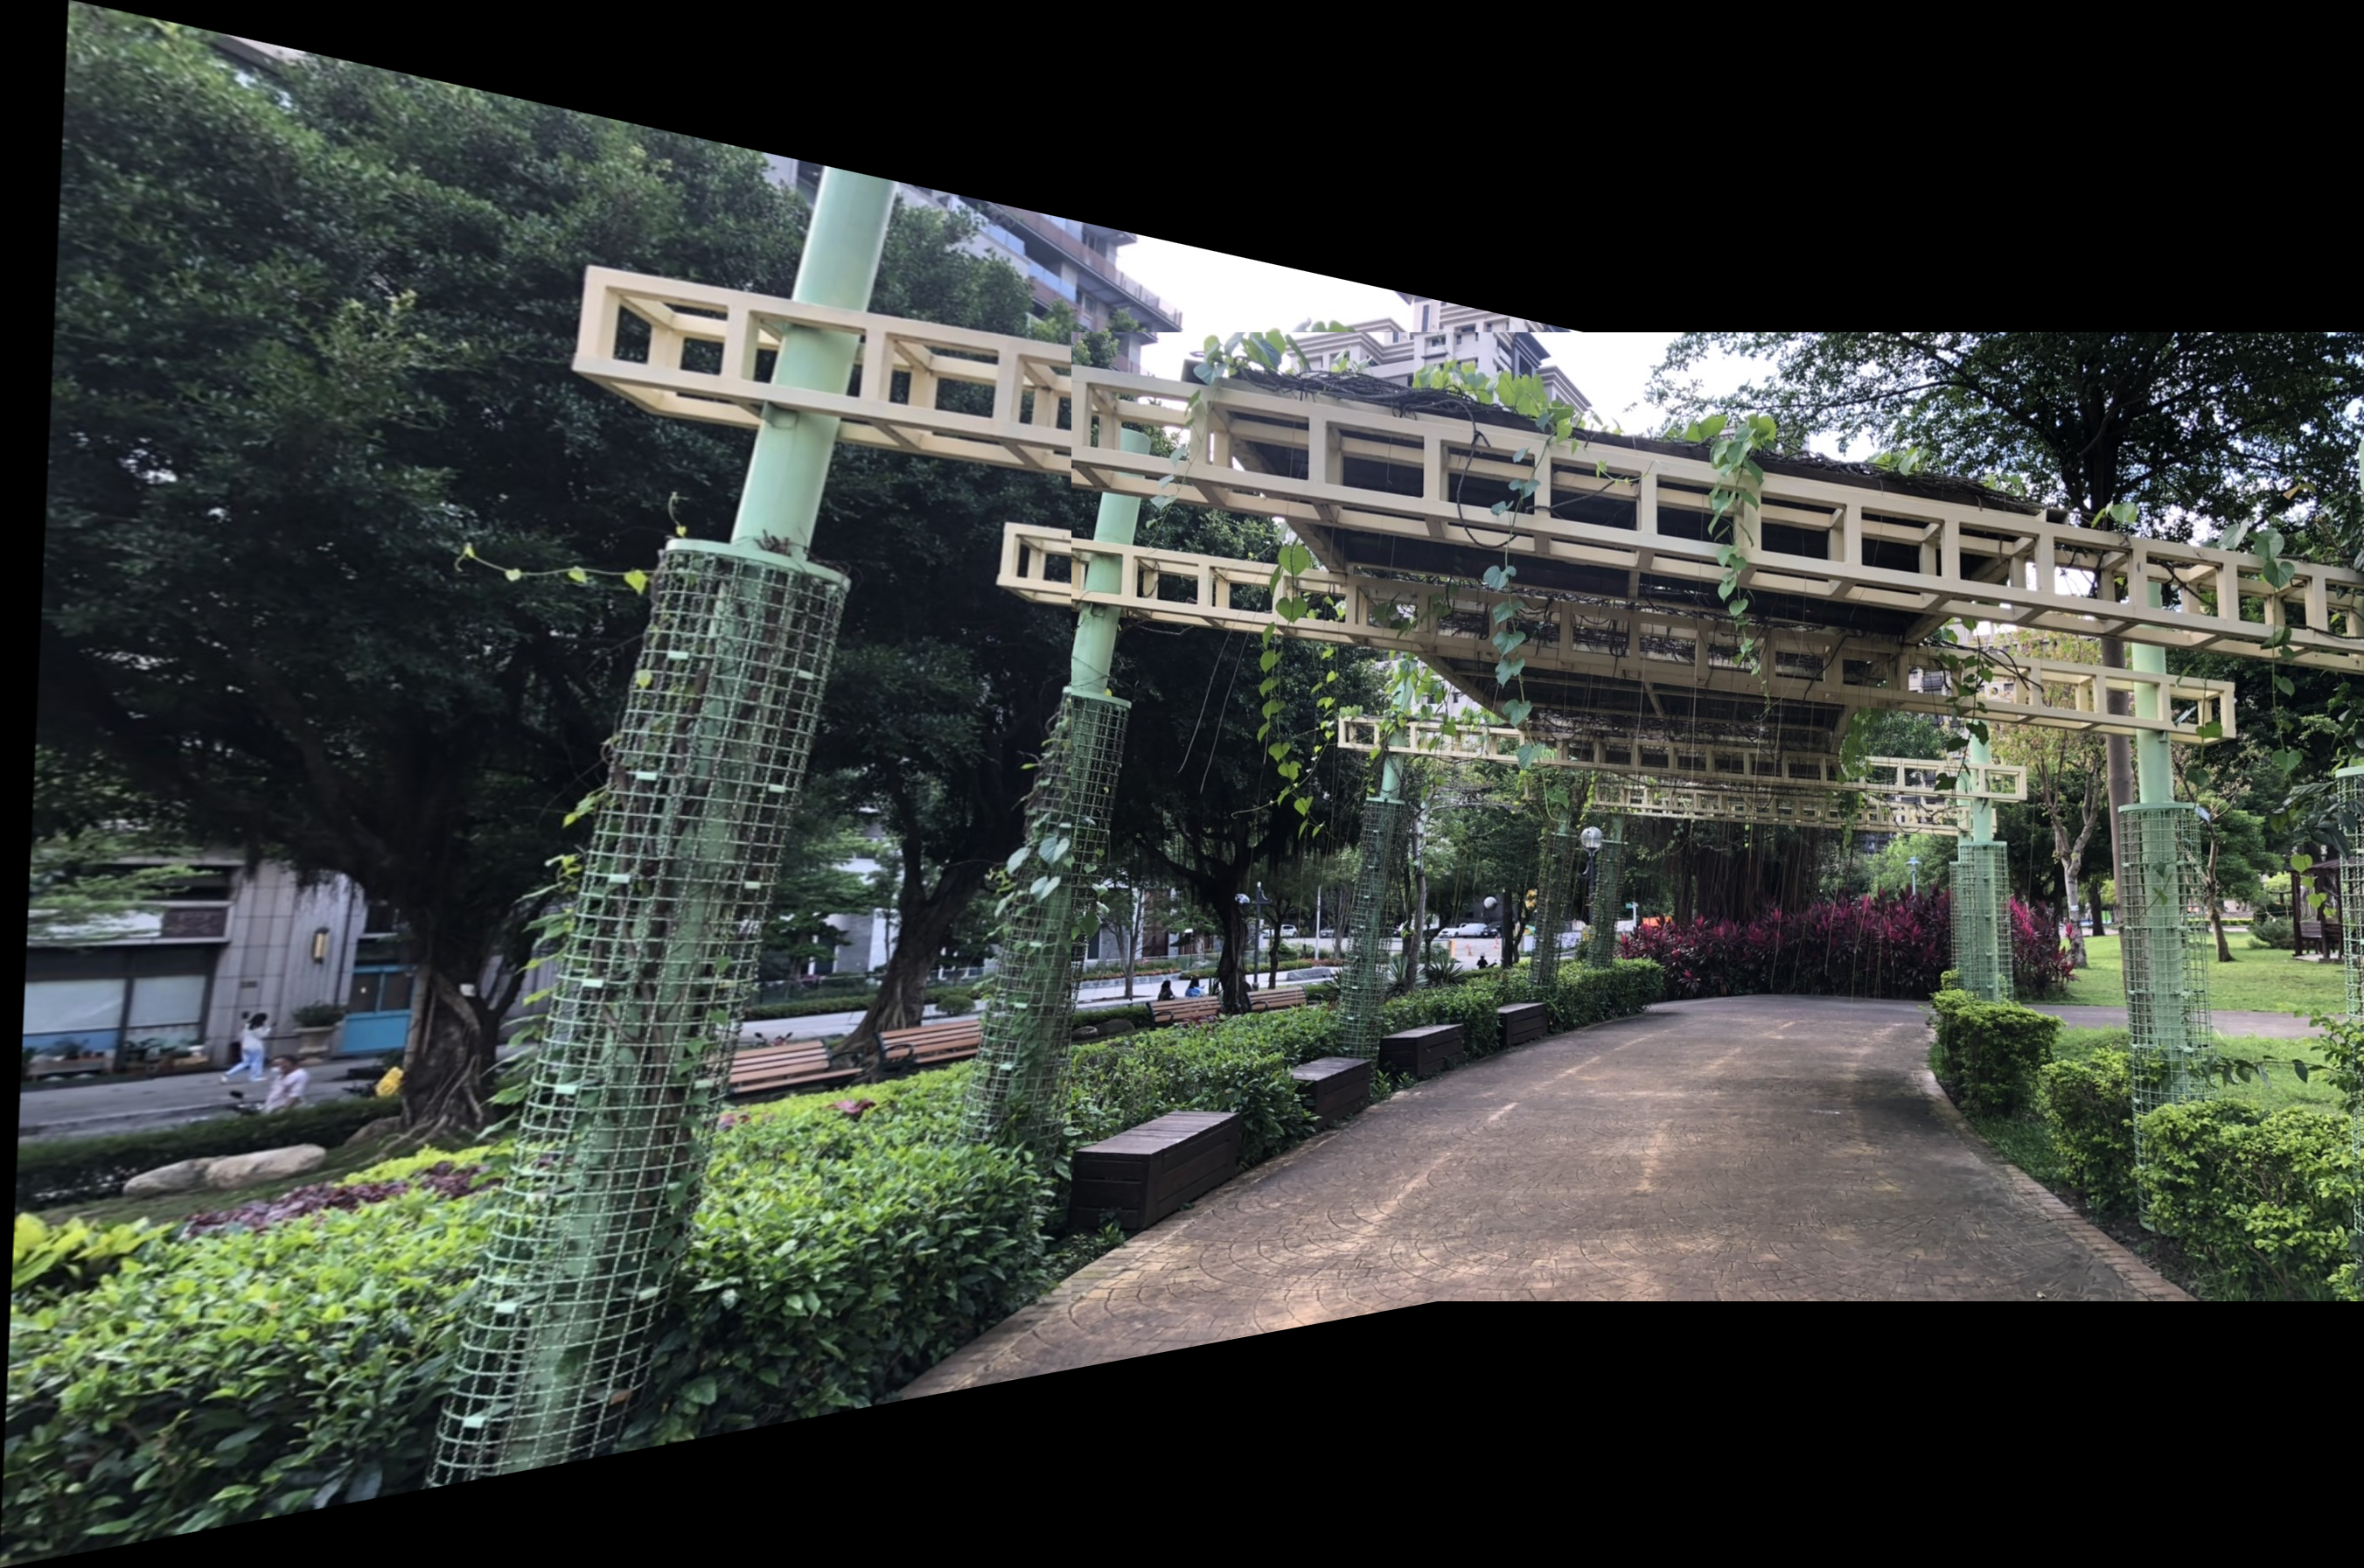

In [24]:
from google.colab.patches import cv2_imshow
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ train_keypoints[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ test_keypoints[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

    cv2_imshow(result)

### 3. (Bonus) Warping transformation (10%)
#### Please read the tutorials and the documentations of __cv2.Stitcher__, and  compare the differences between the panorama below and the panorama from the last question. Write down your observation. 
##### ___(No need to implement for this part!)___

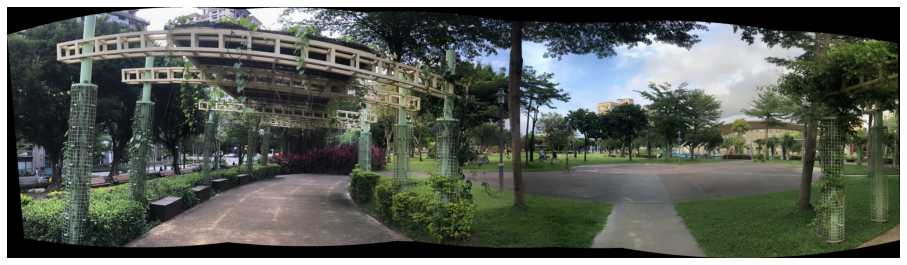

In [26]:
path = "./Data"
img_list = [cv2.imread(i) for i in sorted(glob.glob(os.path.join(path, "*.jpg")))]
sticher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)
ret, pano = sticher.stitch(img_list)
plt.figure(figsize=(16,8))
plt.imshow(pano[:,:,::-1])
plt.axis("off")
plt.show()